In [1]:
import autograd
import autograd.numpy as np
import matplotlib.pyplot as plt
from PIL import Image 
import os
import IPython.display
import time
from astropy.nddata.utils import Cutout2D
from scipy import ndimage

In [2]:
class BubbleEvent:
    def __init__(self, File):
        self.FileName = File
        self.Bot1PixelArray, self.Bot2PixelArray = BubbleEvent.GetPixelArray(self.FileName) #gets 2d array of pixel intensities
        self.Date, self.Run, self.EventID = BubbleEvent.GetRunInfo(self.FileName) #parses image name to get event info
        self.BubbleCount = 0
    def GetPixelArray(FileName):
        im = Image.open(FileName)
        PixelArray = np.asarray(im)
        Cutout = Cutout2D(PixelArray, (530,140), 235) #just cut out the parts of the image with bottles
        Bot1PixelArray = Cutout.data
        PixelArray =ndimage.rotate(PixelArray, -45)
        Cutout2 = Cutout2D(PixelArray, (270,310), 235) #other bottle view
        Bot2PixelArray = Cutout2.data
        return Bot1PixelArray, Bot2PixelArray
    def GetRunInfo(File):
        Date = int(File.split("/")[-1].split("_")[0]) #file should be date_run_event
        Run = int(File.split("/")[-1].split("_")[1])
        Event = int("{}{}{}".format(Date, Run,File.split("/")[-1].split("_")[2])) 
        return Date, Run, Event

def GetBubbleCount(Event, BubbleInfo):
    EventID = Event.EventID
    Cut = BubbleInfo[:,0]==EventID
    if(Cut.sum()!=1): #some events have 2 different bubble count entries
        Event.BubbleCount=9999
    else:
        Event.BubbleCount = int(BubbleInfo[Cut,1])
    
def GetAllDiffImages():
    path = "../bubbleimages/difffirst/"
    Files = np.array(["{}{}".format(path,file) for file in os.listdir(path) if os.path.isfile(os.path.join(path, file))])
    return Files

In [3]:
#Most of the memory is stored in pixel arrays. We will want to process down the images immediately
BubbleCountInfo = np.genfromtxt("../bubbleimages/bubnums.csv", delimiter=",")
DiffImages = GetAllDiffImages()
Events = []
Start=time.time()
SkippedEventCount=0
#for i in range(0, len(DiffImages)):
for i in range(0, 2800):
    Event = BubbleEvent(DiffImages[i])
    GetBubbleCount(Event, BubbleCountInfo)
    if(Event.BubbleCount == 9999):
        SkippedEventCount = SkippedEventCount + 1
        continue
    Events.append(Event)
    if(i%int(len(DiffImages)/10) == 0 ):
        print("On {} of {}, {}".format(i, len(DiffImages), time.time()-Start))
Events = np.asarray(Events, dtype=BubbleEvent) #make an np array to make things nicer
print("Skipped {} Events".format(SkippedEventCount))

On 0 of 24697, 0.10063505172729492
On 2469 of 24697, 140.9567461013794
Skipped 17 Events


In [4]:
#extract useful params for our events with a diff image
def ExtractBubbles(event):
    return event.BubbleCount

#Doesnt work well
def GetPixelArrays(events):
    Pixels=[]
    for i in range(0, len(events)):
        Pixels.append([events[i].Bot1PixelArray, events[i].Bot2PixelArray])
    Pixels = np.array(Pixels)
    return Pixels

GetCountArray = np.vectorize(ExtractBubbles)
Counts = GetCountArray(Events)
PixelArrays = GetPixelArrays(Events)
for i in range(0, max(Counts)+1):
    Cut = Counts==i
    print("{} Events with {} Bubbles".format(Cut.sum(), i))

1971 Events with 0 Bubbles
787 Events with 1 Bubbles
25 Events with 2 Bubbles


# Playing with edge detection

0 Bubbles in ../bubbleimages/difffirst/20170706_5_48_difffirst.bmp
[8782.   8765.25 1734.5 ] 19281.75


<Figure size 720x720 with 0 Axes>

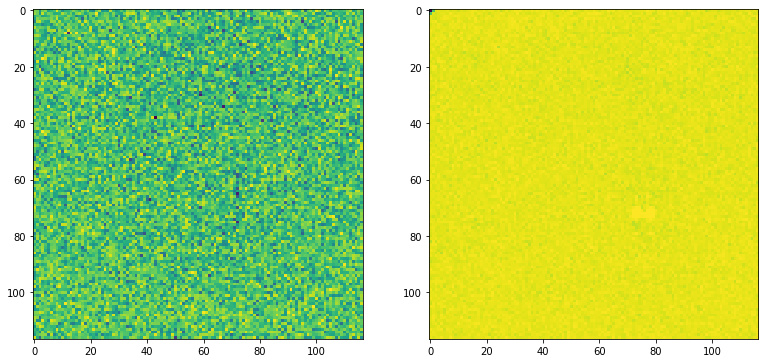

0 Bubbles in ../bubbleimages/difffirst/20170708_6_62_difffirst.bmp
[9277.   9094.25 1700.  ] 20071.25


<Figure size 720x720 with 0 Axes>

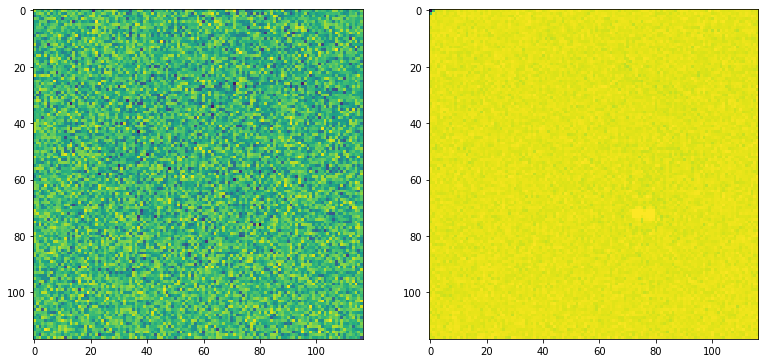

0 Bubbles in ../bubbleimages/difffirst/20170625_0_27_difffirst.bmp
[ 9166.5  10134.25  1954.5 ] 21255.25


<Figure size 720x720 with 0 Axes>

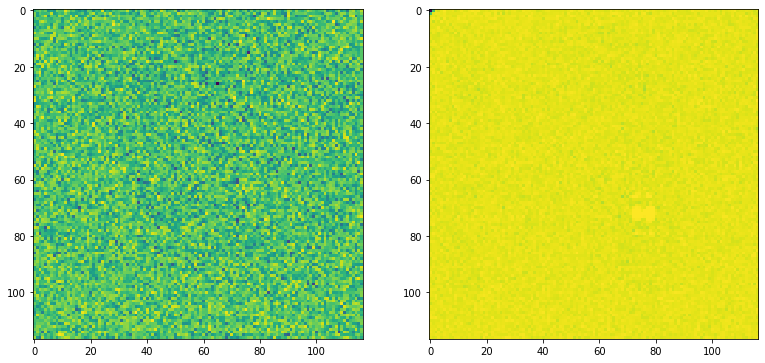

0 Bubbles in ../bubbleimages/difffirst/20170925_0_62_difffirst.bmp
[10234.   9120.5  1393. ] 20747.5


<Figure size 720x720 with 0 Axes>

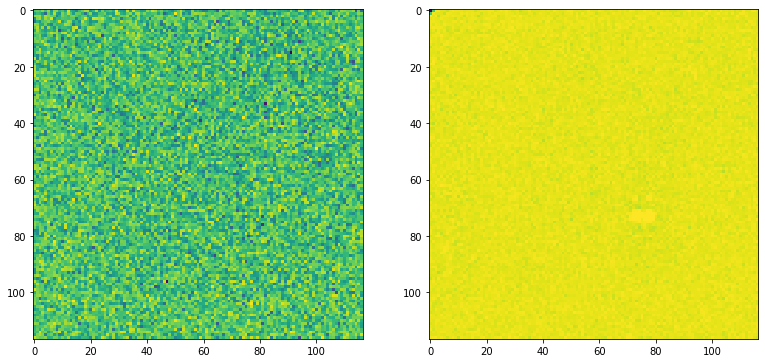

0 Bubbles in ../bubbleimages/difffirst/20170803_3_37_difffirst.bmp
[9052.   9700.75 1715.5 ] 20468.25


<Figure size 720x720 with 0 Axes>

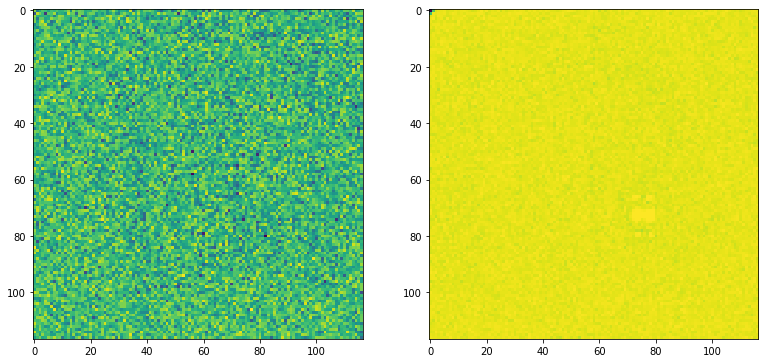

0 Bubbles in ../bubbleimages/difffirst/20170630_7_78_difffirst.bmp
[ 9412.5  10390.75  1914.  ] 21717.25


<Figure size 720x720 with 0 Axes>

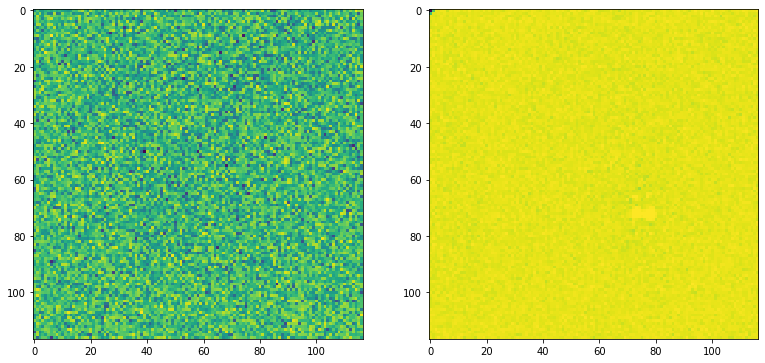

1 Bubbles in ../bubbleimages/difffirst/20171003_4_23_difffirst.bmp
[13572.  14609.5 15532.5] 43714.0


<Figure size 720x720 with 0 Axes>

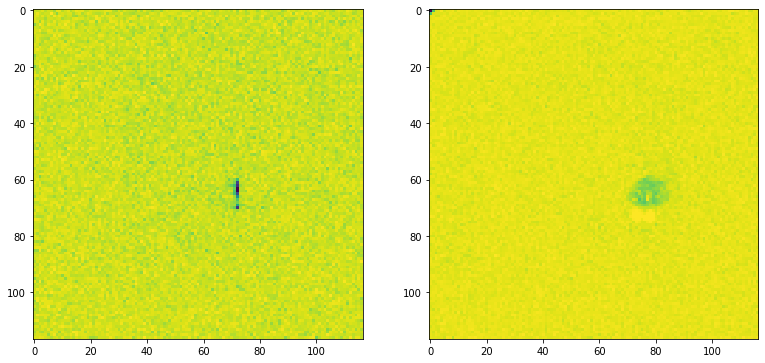

0 Bubbles in ../bubbleimages/difffirst/20170924_0_52_difffirst.bmp
[10728.75  9987.25  1887.  ] 22603.0


<Figure size 720x720 with 0 Axes>

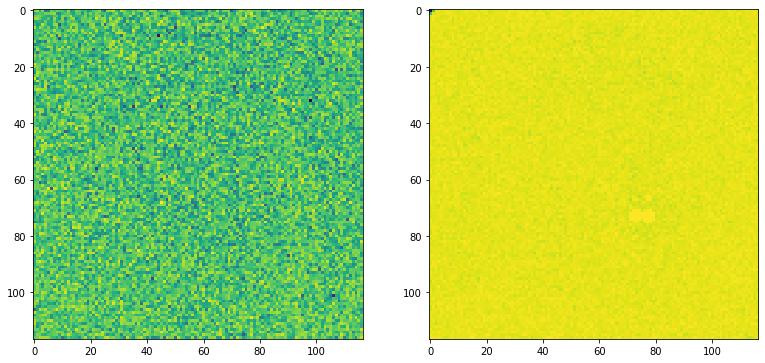

0 Bubbles in ../bubbleimages/difffirst/20170630_8_60_difffirst.bmp
[17423.25 19152.   16244.5 ] 52819.75


<Figure size 720x720 with 0 Axes>

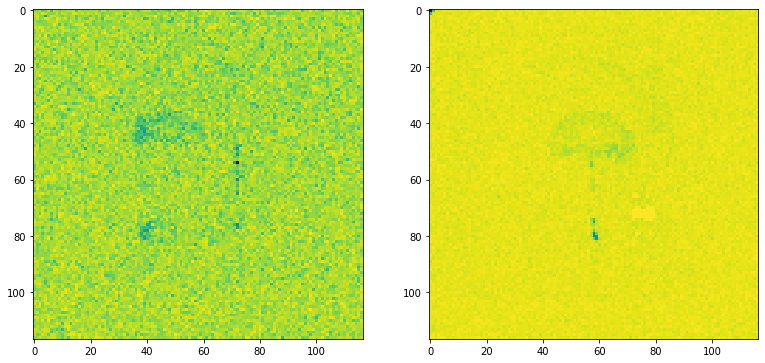

0 Bubbles in ../bubbleimages/difffirst/20170701_3_81_difffirst.bmp
[9495.75 8753.75 1795.5 ] 20045.0


<Figure size 720x720 with 0 Axes>

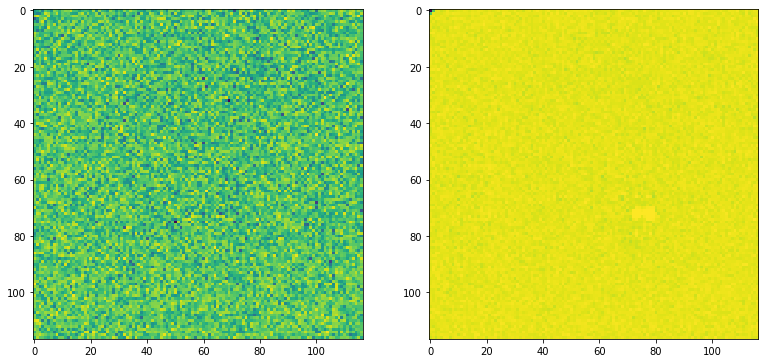

In [5]:
def DownSampleTheArray(BoxSize, Array):
    NewArray = np.zeros((int(np.shape(Array)[0]/BoxSize), int(np.shape(Array)[1]/BoxSize)))
    NewI=0
    NewJ=0
    i=0
    j=0
    while(NewI<np.shape(NewArray)[0]):
        NewJ=0
        j=0
        while(NewJ<np.shape(NewArray)[1]):
            NewArray[NewI, NewJ] = np.mean(Array[i:i+BoxSize, j:j+BoxSize])
            j = j + BoxSize
            NewJ = NewJ+1
        i = i + BoxSize
        NewI = NewI+1
    return NewArray

def GetEdgeFeatures(PixelArray):
    HorizontalKernal = np.array([[1,0,-1],[2,0,-2], [1,0,-1]])
    VerticalKernal = HorizontalKernal.T
    EdgeArray = np.zeros(3) #histograms of edge directions
    Step = 3
    i=0
    j=0
    Significant = 35
    while(i < np.shape(PixelArray)[0]-2):
        j=0
        while(j < np.shape(PixelArray)[1]-2):
            XConvalution = PixelArray[i:i+Step, j:j+Step]*HorizontalKernal
            XConvalution = np.sum(XConvalution)
            YConvalution = PixelArray[i:i+Step, j:j+Step]*VerticalKernal
            YConvalution = np.sum(YConvalution)
            #histogram and adding convalution result seem to perform similarly
            if(np.abs(XConvalution)>Significant and np.abs(YConvalution)<=Significant):
                EdgeArray[0] = EdgeArray[0]+ np.abs(XConvalution) #big horizontal edge
            elif(np.abs(XConvalution)<=Significant and np.abs(YConvalution)>Significant):
                EdgeArray[1] = EdgeArray[1]+ np.abs(YConvalution) #big verical edge
            elif(np.abs(XConvalution)>Significant and np.abs(YConvalution)>Significant):
                EdgeArray[2] = EdgeArray[2]+ np.abs(XConvalution) + np.abs(YConvalution) #big diagonal
            #j =j+Step
            j=j+1
        #i =i+Step
        i=i+1
    return EdgeArray

#for i in range(0, 10):
Ev=0
i=0
while(Ev <  10):
    #if(Counts[i]==0):
    #    i=i+1
    #    continue
    Ev=Ev+1
    print("{} Bubbles in {}".format(Counts[i], Events[i].FileName))
    plt.figure(figsize=(10,10))
    fig, axs = plt.subplots(1, 2, figsize=(13,13))
    #2 does good. 5+ does good on all but first one
    Temp1 = DownSampleTheArray(2, PixelArrays[i][0])
    Edge1 = GetEdgeFeatures(Temp1)
    Temp2 = DownSampleTheArray(2, PixelArrays[i][1])
    Edge2 = GetEdgeFeatures(Temp2)
    print(Edge1+Edge2, np.sum(Edge1+Edge2))
    axs[0].imshow(Temp1)
    axs[1].imshow(Temp2)
    plt.show()
    i=i+1

TestingHists = []

for i in range(0, len(Counts)):
    Temp1 = DownSampleTheArray(2, PixelArrays[i][0])
    Edge1 = GetEdgeFeatures(Temp1)
    Temp2 = DownSampleTheArray(2, PixelArrays[i][1])
    Edge2 = GetEdgeFeatures(Temp2)
    TestingHists.append([Edge1, Edge2])

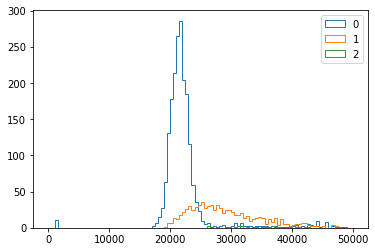

In [6]:
TestingHists = np.asarray(TestingHists)
for i in range(0, max(Counts)+1):
    Cut = Counts==i
    RightEvents = TestingHists[Cut]
    Sums = np.sum(np.sum(RightEvents, axis=1), axis=1)
    plt.hist(Sums, histtype='step', bins=100, range=[0,50000], label=i)
plt.legend()
plt.show()

# Playing with blob detection

1 Bubbles in ../bubbleimages/difffirst/20171003_4_23_difffirst.bmp


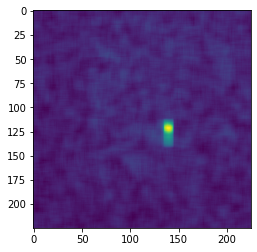

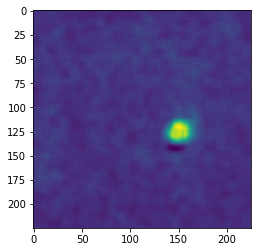

15072522.066488244
------
1 Bubbles in ../bubbleimages/difffirst/20170928_5_86_difffirst.bmp


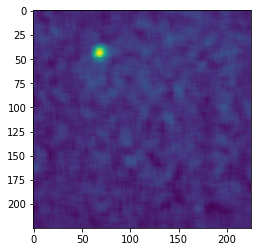

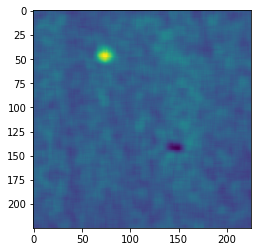

15085802.451734666
------
1 Bubbles in ../bubbleimages/difffirst/20170705_3_18_difffirst.bmp


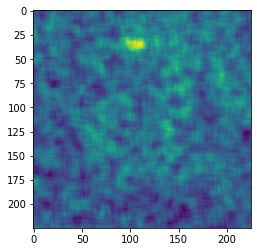

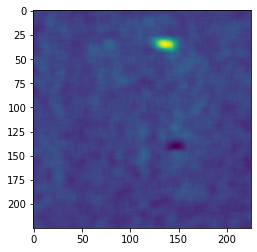

15081985.808383608
------
1 Bubbles in ../bubbleimages/difffirst/20171003_5_29_difffirst.bmp


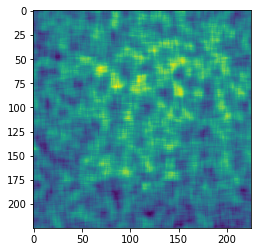

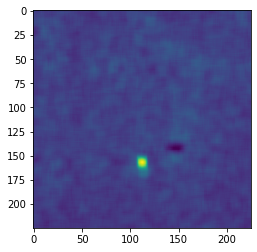

15078984.797057062
------
1 Bubbles in ../bubbleimages/difffirst/20170803_1_35_difffirst.bmp


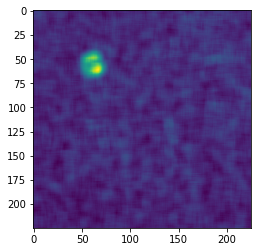

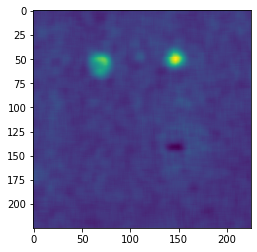

15080105.734188335
------
1 Bubbles in ../bubbleimages/difffirst/20170804_1_60_difffirst.bmp


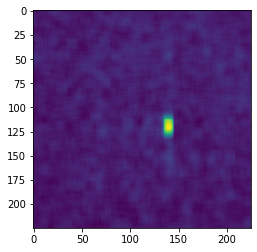

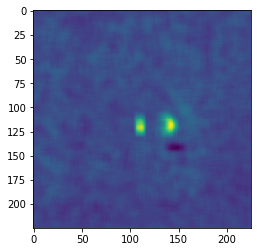

15081558.577931518
------
1 Bubbles in ../bubbleimages/difffirst/20171001_3_39_difffirst.bmp


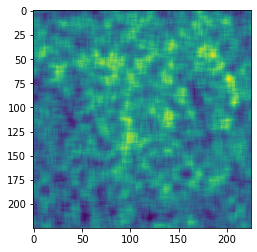

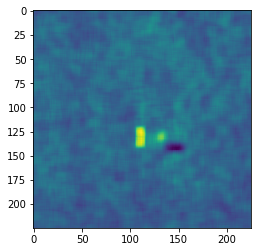

15085925.815328717
------
1 Bubbles in ../bubbleimages/difffirst/20170927_1_16_difffirst.bmp


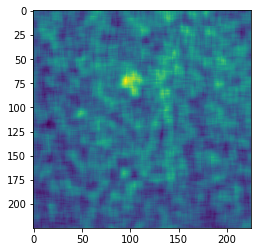

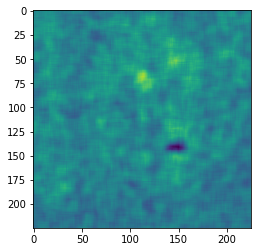

15087463.178066185
------
1 Bubbles in ../bubbleimages/difffirst/20170711_16_26_difffirst.bmp


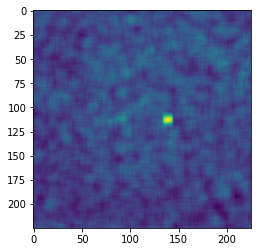

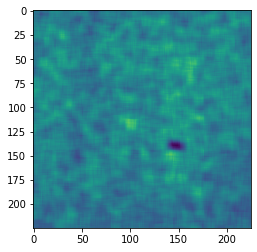

15082434.723350015
------
1 Bubbles in ../bubbleimages/difffirst/20171009_8_5_difffirst.bmp


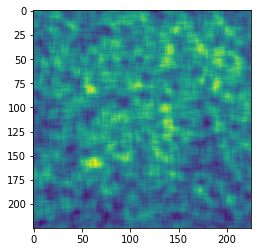

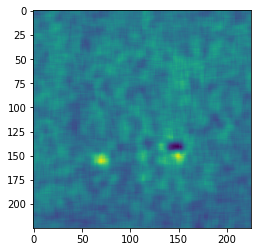

15080822.406209689
------


In [7]:
def LaplaceOfGaussKernel(x, y, sigma):
    PointsX, PointsY = np.meshgrid(x,y)
    r = PointsX**2 + PointsY**2
    LoG = -1/(np.pi*sigma**4)*(1 - r/(2*sigma**2))*np.exp(-r/(2*sigma**2))
    return LoG*100

def Convolve(PixelArray, Kernel):
    Size = int((np.shape(Kernel)[0]-1)/2)
    i = Size
    j = Size
    #2*size since we cut out at two ends
    Convalution = np.zeros((np.shape(PixelArray)[0]-2*Size, np.shape(PixelArray)[1]-2*Size))
    FillI=0
    FillJ=0
    while(i < np.shape(PixelArray)[0]-Size):
        j = Size
        FillJ=0
        while(j < np.shape(PixelArray)[1]-Size):
            ConvalutionResult = PixelArray[i-Size:i+Size+1, j-Size:j+Size+1]*Kernel
            Convalution[FillI,FillJ] = ConvalutionResult.sum()
            FillJ = FillJ + 1
            j = j + 1
        FillI = FillI + 1
        i = i + 1
    return Convalution
            

def GetBlobs(PixelArray, Loud=True, Playing=False):
    I = np.arange(-5,6)
    J = np.arange(-5,6)
    Kernel=LaplaceOfGaussKernel(I, J, 8.3)
    Convalution = Convolve(PixelArray, Kernel)
    if(Loud):
        plt.imshow(Convalution)
        plt.show()
    if(Playing):
        return Convalution
    cut = Convalution>-6000
    #print("Min Val {}".format(np.min(Convalution)))
    #print("Max Val {}".format(np.max(Convalution)))
    return np.sum(np.abs(Convalution[cut]))
    #return np.max((Convalution))
Ev=0
i=0
while(Ev<10):
    if(Counts[i] <1):
        i=i+1
        continue
    print("{} Bubbles in {}".format(Counts[i], Events[i].FileName))
    BlobSum=GetBlobs(PixelArrays[i,0]) + GetBlobs(PixelArrays[i,1])
    print(BlobSum)
    print("------")
    i=i+1
    Ev=Ev+1

Conval = []
for i in range(0, len(Counts)):
    #Cut = Counts==i
    #CheckingHist = np.zeros(Cut.sum())
    #for j in range(0, Cut.sum()):
        #CheckingHist[j] = GetBlobs(PixelArrays[Cut][j][0], Loud=False) + GetBlobs(PixelArrays[Cut][j][1], Loud=False)
    Conval.append([GetBlobs(PixelArrays[i][0], Loud=False, Playing=True), GetBlobs(PixelArrays[i][1], Loud=False, Playing=True)])
    #plt.hist(CheckingHist, histtype="step", range=[-1, 4e6], bins=200, label="{} Bubbles".format(i), density=True)
    #if(i==1):
    #    print(np.min(CheckingHist))
#plt.legend()
#plt.show()

0 1971
1 787
2 25


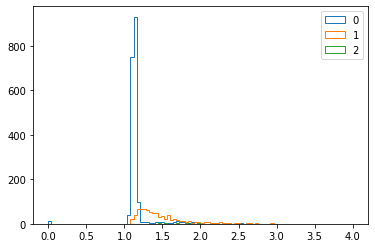

In [11]:
Conval = np.asarray(Conval)
for i in range(0, max(Counts)+1):
    Cut = Counts==i
    print(i, Cut.sum())
    NewConval = Conval[Cut] #Just this bubble count
    TempThing = []
    for j in range(0, Cut.sum()):
        TempThing.append(np.std(NewConval[j,0]) + np.std(NewConval[j,1]))
    plt.hist(TempThing, label=i, bins=100, range=[0,4], histtype='step')
plt.legend()
plt.show()

[] -148.05867632520872 -147.2280043699999 (38, 142)


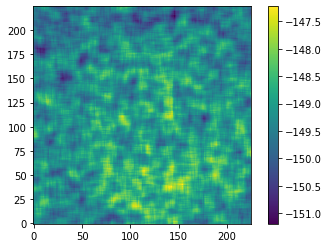

[] -148.05867632520872 -147.2280043699999 (38, 142)


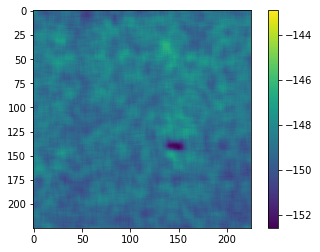

[] -148.15592327486277 -147.4897630309354 (50, 126)


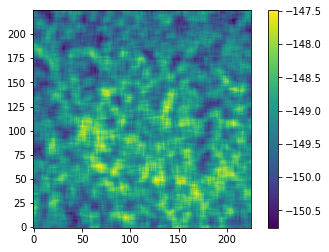

[] -148.15592327486277 -147.4897630309354 (50, 126)


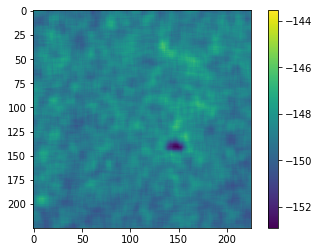

[] -149.1827660409836 -147.2478298320569 (43, 119)


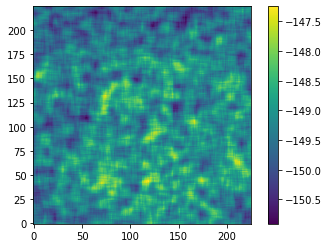

[] -149.1827660409836 -147.2478298320569 (43, 119)


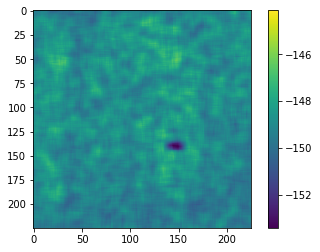

[] -148.77438003017278 -146.9774092693152 (101, 202)


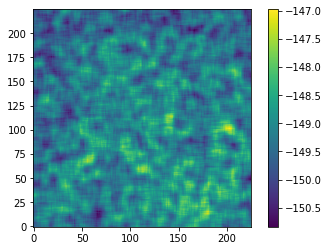

[] -148.77438003017278 -146.9774092693152 (101, 202)


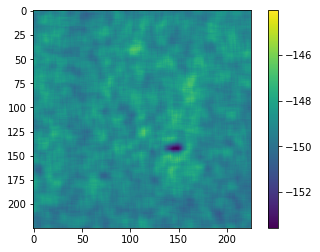

[] -147.52002850910787 -147.18452558777096 (91, 72)


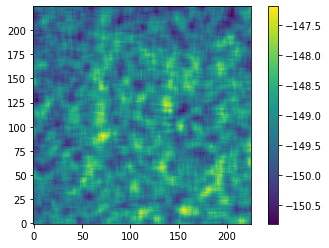

[] -147.52002850910787 -147.18452558777096 (91, 72)


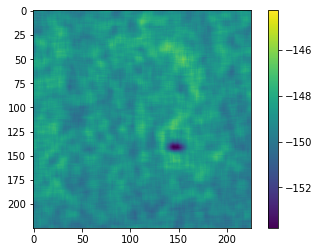

[] -148.5970953136268 -147.10576002670743 (47, 138)


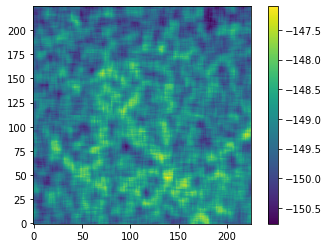

[] -148.5970953136268 -147.10576002670743 (47, 138)


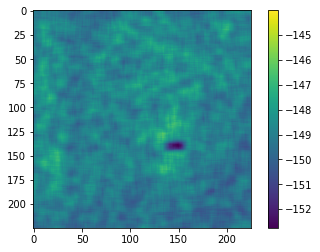

[[122, 139]] -133.33027760573702 -133.33027760573702 (122, 139)


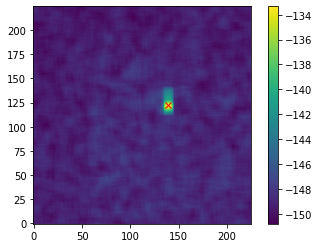

[[121, 151], [128, 144]] -133.33027760573702 -133.33027760573702 (122, 139)


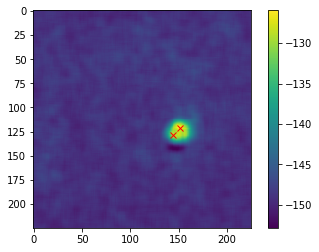

[] -148.3063110097539 -147.13911689354606 (63, 62)


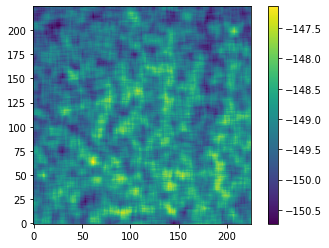

[] -148.3063110097539 -147.13911689354606 (63, 62)


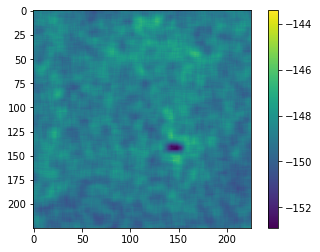

[[72, 86], [77, 104], [80, 72], [80, 111], [108, 141], [152, 75]] -148.01980496609352 -142.2944872592948 (80, 72)


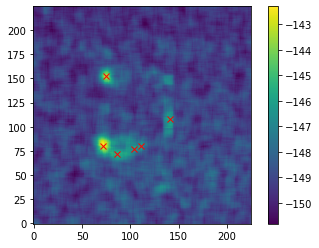

[[34, 119], [40, 154], [62, 158], [71, 107], [72, 102], [72, 119], [77, 91], [77, 155], [94, 91], [95, 126], [100, 111], [120, 112], [155, 112]] -148.01980496609352 -142.2944872592948 (80, 72)


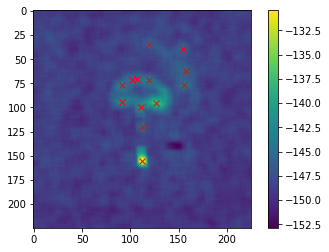

[] -147.91518864194205 -146.98004418670362 (149, 94)


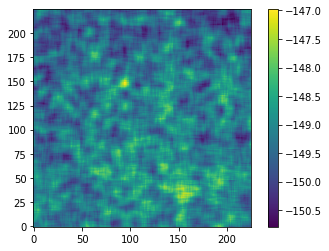

[] -147.91518864194205 -146.98004418670362 (149, 94)


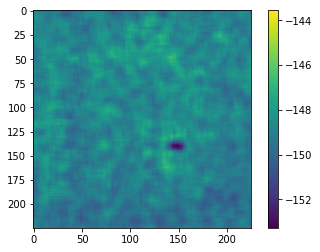

[] -147.6795814261808 -147.19921750191904 (13, 100)


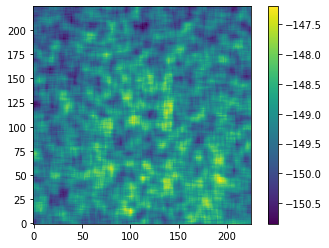

[] -147.6795814261808 -147.19921750191904 (13, 100)


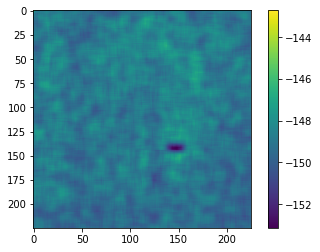

[[43, 68]] -148.5651481691464 -137.77962096145154 (43, 68)


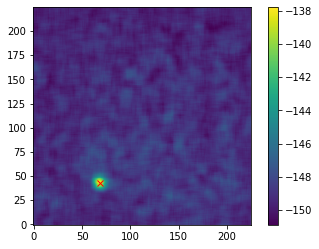

[[47, 74]] -148.5651481691464 -137.77962096145154 (43, 68)


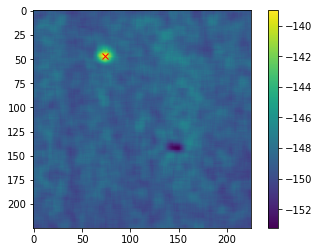

[] -148.47329067243652 -147.25191298548745 (40, 65)


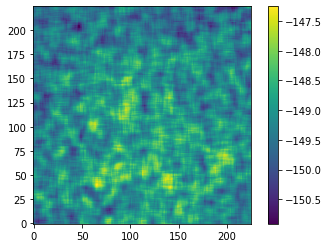

[] -148.47329067243652 -147.25191298548745 (40, 65)


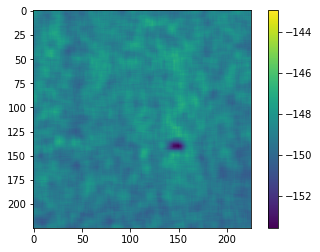

[[35, 109]] -147.39562968705968 -145.87732634040518 (35, 109)


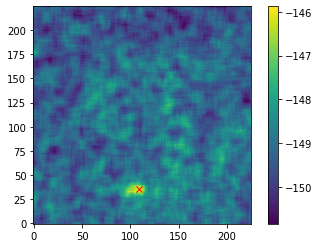

[[35, 135]] -147.39562968705968 -145.87732634040518 (35, 109)


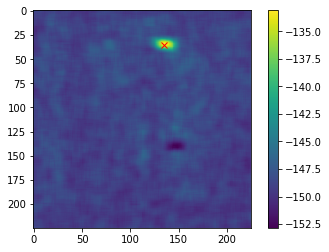

[] -148.33536605587548 -146.97006590854488 (78, 86)


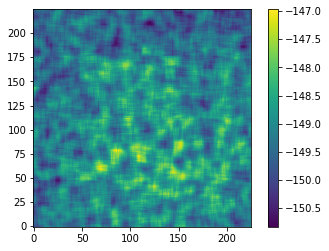

[[157, 112]] -148.33536605587548 -146.97006590854488 (78, 86)


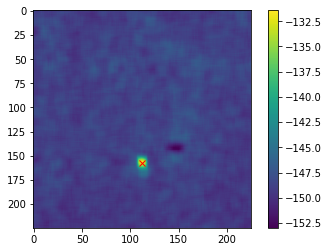

[[49, 62], [61, 67]] -148.43449421564367 -138.29040512305846 (61, 67)


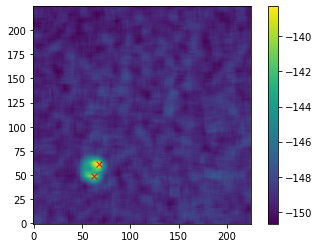

[[51, 71], [51, 147]] -148.43449421564367 -138.29040512305846 (61, 67)


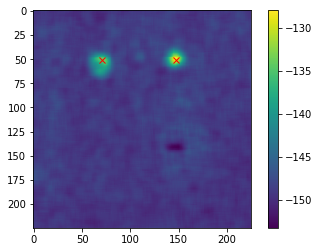

[] -148.36619000243485 -147.15993408260502 (53, 189)


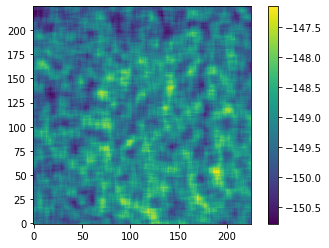

[] -148.36619000243485 -147.15993408260502 (53, 189)


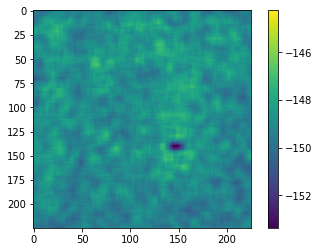

[] -147.9680409828819 -147.31963099527815 (146, 96)


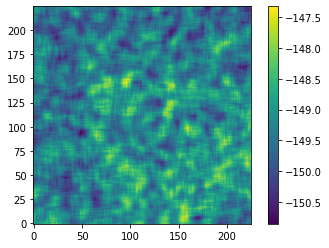

[] -147.9680409828819 -147.31963099527815 (146, 96)


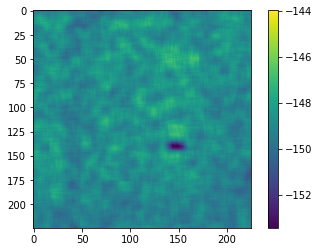

[[120, 139]] -130.87847107969776 -130.6835996333836 (120, 139)


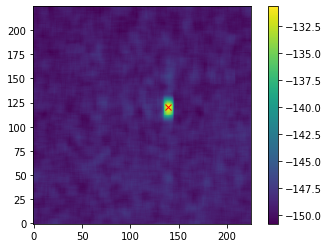

[[118, 141], [121, 111]] -130.87847107969776 -130.6835996333836 (120, 139)


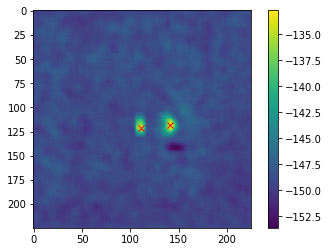

[] -148.68662393706785 -146.8335620909668 (51, 181)


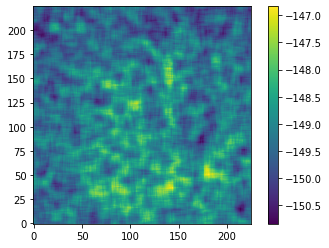

[] -148.68662393706785 -146.8335620909668 (51, 181)


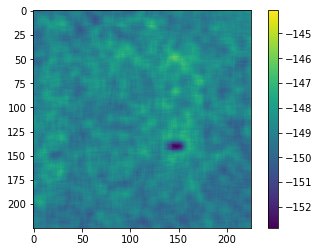

0 1971
1 787
2 25


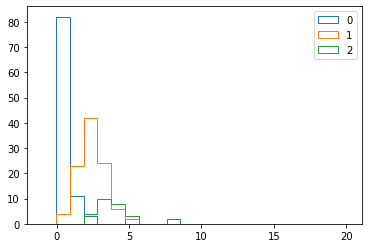

In [83]:
#want to count the number of maxima in each image
#could use a basic peak finder
def FindPeaks(Array, boxsize): #finds the number of elements that are bigger than all neighbors in some box
    FoundPeak = False
    PeakCount=0
    PeakLoc=[]
    for i in range(boxsize, np.shape(Array)[0]-boxsize):
        for j in range(boxsize, np.shape(Array)[1]-boxsize):
            CurrentElem = Array[i,j]
            BoxElements = Array[i-boxsize:i+boxsize+1, j-boxsize:j+boxsize]
            if(np.max(BoxElements)<=CurrentElem and CurrentElem>np.mean(Array)+3):
                FoundPeak=True
            if(FoundPeak):
                PeakCount=PeakCount+1
                PeakLoc.append([i,j])
                FoundPeak = False #reset the bool
    return PeakCount, PeakLoc


for i in range(0, 200):
    plt.imshow(Conval[i,0], origin='lower')
    F = FindPeaks(Conval[i,0], 4)[1]
    print(F, Conval[i,0, 122, 139], np.max(Conval[i,0]), np.unravel_index(np.argmax(Conval[i,0]), np.shape(Conval[i,0])))
    for q in range(0, len(F)):
        plt.plot(F[q][1], F[q][0], marker='x', color='r')
    plt.colorbar()
    plt.show()
    plt.imshow(Conval[i,1])
    F = FindPeaks(Conval[i,1], 4)[1]
    print(F, Conval[i,0, 122, 139], np.max(Conval[i,0]), np.unravel_index(np.argmax(Conval[i,0]), np.shape(Conval[i,0])))
    for q in range(0, len(F)):
        plt.plot(F[q][1], F[q][0], marker='x', color='r')
    plt.colorbar()
    plt.show()

for i in range(0, max(Counts)+1):
    Cut = Counts==i
    print(i, Cut.sum())
    NewConval = Conval[Cut] #Just this bubble count
    TempThing = []
    for j in range(0, Cut.sum()):
        if(j>100):
            break
        TempThing.append(FindPeaks(NewConval[j,0], 15)[0] + FindPeaks(NewConval[j,1], 15)[0])
    plt.hist(TempThing, label=i,range=[-1, 20], bins=22, histtype='step')
plt.legend()
plt.show()

# Isolating the jars

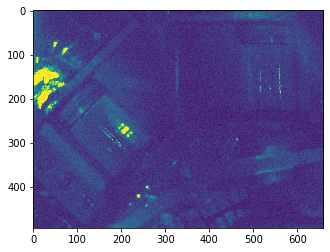

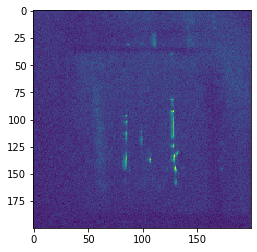

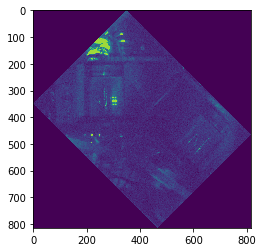

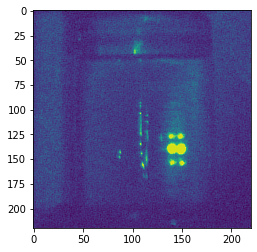

In [181]:
#Just have the jar parts

im = Image.open("../bubbleimages/trig/20170925_0_63_trig.bmp")
Array = np.asarray(im, dtype=int)
IVals = np.arange(0, np.shape(Array)[0],1)
JVals = np.arange(0, np.shape(Array)[1],1)

Cut1 = (IVals>-10)*(IVals<2750)
plt.imshow(Array[Cut1,:])
plt.show()
Cutout = Cutout2D(Array, (530,140), 200)
plt.imshow(Cutout.data)
plt.show()

Array=ndimage.rotate(Array, -45)
plt.imshow(Array)
plt.show()
Cutout2 = Cutout2D(Array, (270,310), 220)
plt.imshow(Cutout2.data)
plt.show()